In [ ]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
import numpy as np

from scipy.ndimage import rotate, shift
from scipy.signal import convolve2d

import random

import pywt
from scipy.interpolate import interp2d

import cv2

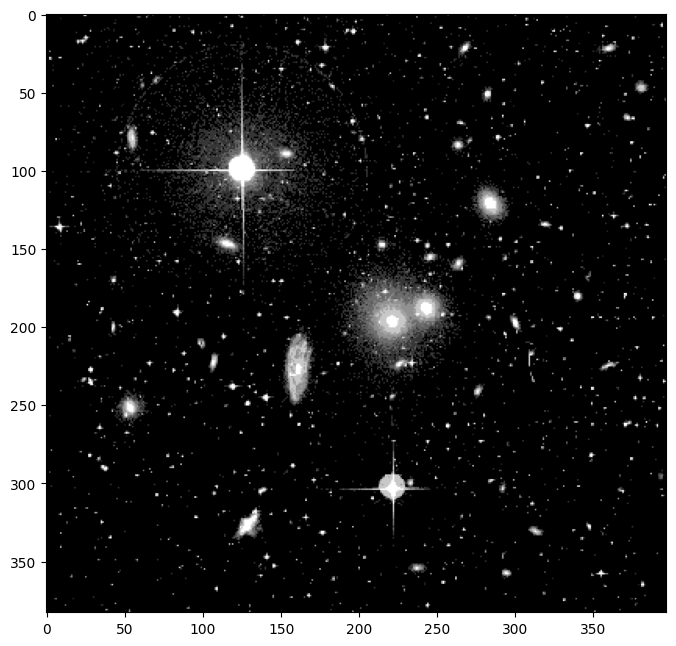

In [ ]:
#image filepath
#file_path = "/content/hydra_poss.gif"
#file_path = "D:/B.TECH/CLASSES/3rd Year/SEM 6/IVP/Project/2/hydra_poss.gif"

I_clean = Image.open("/content/hydra_poss.gif").convert('L')
I_clean = np.array(I_clean)
fig = plt.subplots(1,1,figsize=(8,8))
plt.imshow(I_clean,cmap="gray")

plt.show()

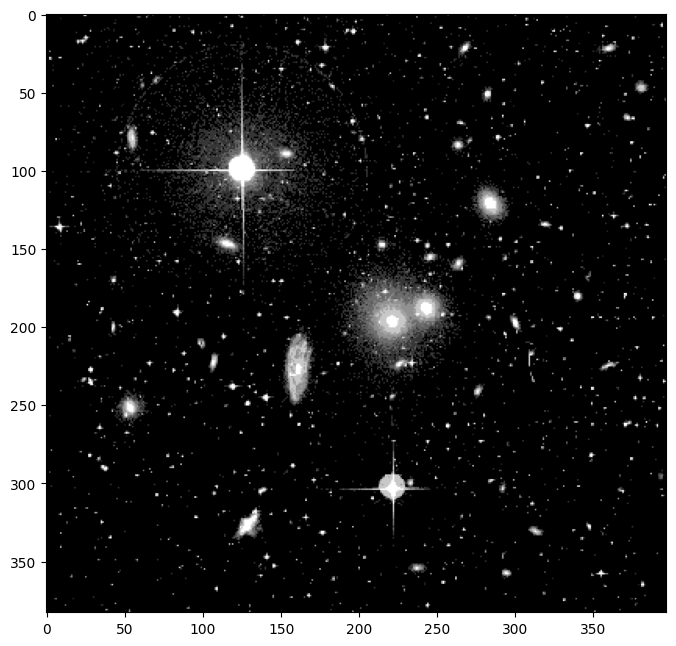

In [ ]:
I_trail = Image.open("/content/hydra_poss.gif").convert('L')
I_trail = np.array(I_trail)
fig = plt.subplots(1,1,figsize=(8,8))
plt.imshow(I_trail,cmap="gray")

plt.show()

In [ ]:
def image_degradation(I,blur=2,var=0.5):
    #I = np.array(I)
    noise = np.random.normal(loc=0, scale=var, size=I.shape)    
    noisy_img = (I + noise)

    img = Image.fromarray(np.uint8(noisy_img))
    #img = img.filter(ImageFilter.BoxBlur(blur))
    
    kernel = [[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]]
    img = convolve2d(img, kernel, mode='same')
    return img, kernel

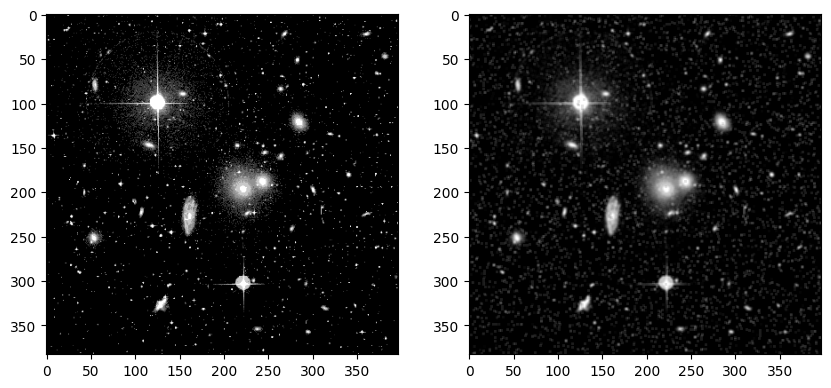

In [ ]:
I_deg, b = image_degradation(I_trail,2,0.5)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(I_trail,cmap="gray")
ax[1].imshow(I_deg,cmap="gray")

plt.show()

In [ ]:
def downsampling(I,size=64):
    x = I
    a = I.shape[0]//size
    b = I.shape[1]//size

    D = np.ones((a,b)) / (a*b)
    
    downsampled_array = np.matmul(D, x)
    downsampled_array = np.matmul(downsampled_array, D.transpose())
    return Image.fromarray(downsampled_array.astype('uint8'))
    
    return y

In [ ]:
def pixel_reduction(I, size):
    img = Image.fromarray(np.uint8(I))
    img = img.resize((size, size), resample=Image.LANCZOS)
    img = np.array(img)
    return img

(64, 64)


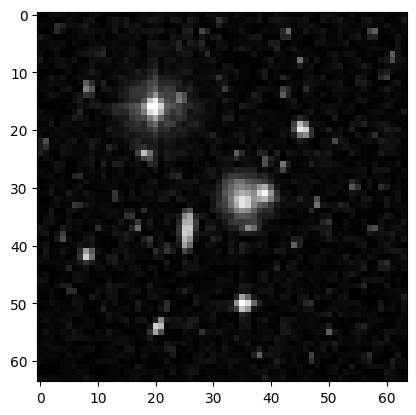

In [ ]:
I_64 = pixel_reduction(I_deg,64)
#y = downsampling(I=I_deg, size=64)

# fig, ax = plt.subplots(1,2,figsize=(10,10))
# ax[0].imshow(y,cmap="gray")
print(I_64.shape)
plt.imshow(I_64,cmap="gray")

plt.show()

In [ ]:
def rotation_and_shift(I):
    shift_amount = np.random.uniform(-0.01, 0.01,2)
    I_shifted = shift(I, shift_amount)

    angle = np.random.uniform(-2, 2)
    I_rotated = rotate(I_shifted, angle, reshape=False)
  
    return I_rotated, shift_amount, angle

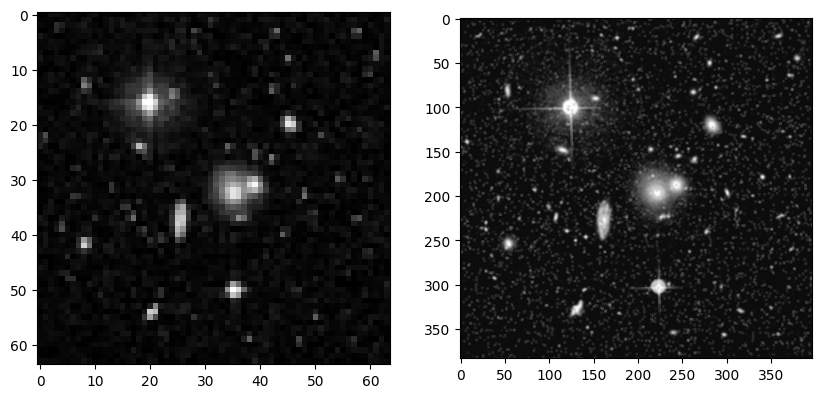

In [ ]:
##generating 16 low-resolution images from the above low resolution image by rotating and shifting by a subpixel amouny
I_lr = []
I_shift_amount = []
I_rot_amount = []

for i in range(16):
    I_rot, shift_amount, rot_amount = rotation_and_shift(I_deg)
    tmp = np.array(I_rot)
    I_lr.append(tmp)
    I_shift_amount.append(shift_amount)
    I_rot_amount.append(rot_amount)
    
I_lr = np.array(I_lr)
I_shift_amount = np.array(I_shift_amount)
I_rot_amount = np.array(I_rot_amount)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(I_64,cmap="gray")
ax[1].imshow(I_lr[0],cmap="gray")

plt.show()

In [ ]:
print(I_lr[0].shape)

(383, 397)


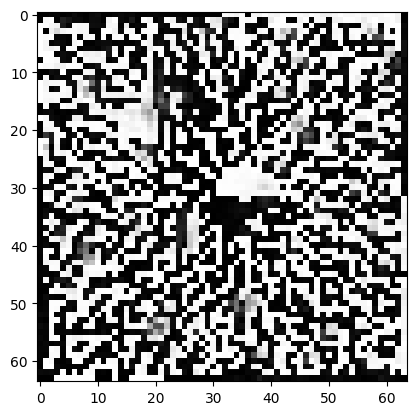

In [ ]:
plt.imshow(I_lr[0] - I_lr[1], cmap = "gray")

## shifts and rotation estimation

In [ ]:
x_shift = []
y_shift = []

for i in I_shift_amount:
    x_shift.append(i[0])
    y_shift.append(i[1])

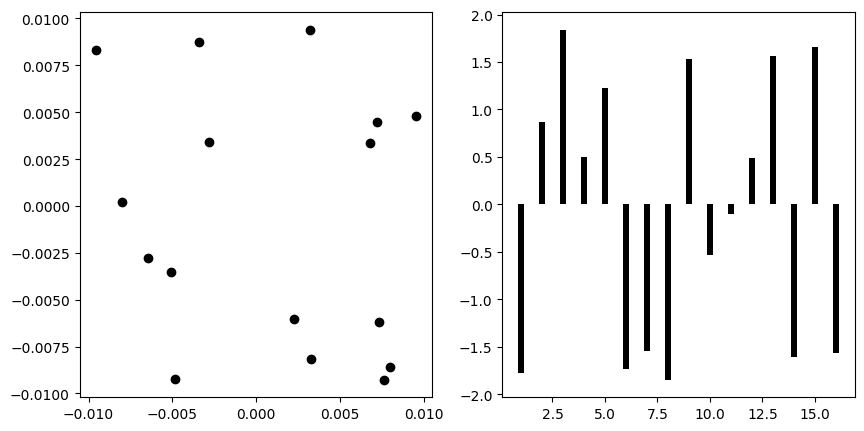

In [ ]:
x = np.arange(1,17)
width = 0.25

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(x_shift, y_shift, color = "k")
ax[1].bar(x,I_rot_amount,width,color = "k")

plt.show()

## Wavelet

In [ ]:
# Define the multivariate normal probability density function
def multivariate_normal_pdf(x, mean, cov):
    n = 2
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi), float(n)/2) * np.power(det,1.0/2))
    x_mu = np.matrix(x - mean)
    result = np.exp(-0.5 * (x_mu * inv * x_mu.T))
    return norm_const * result

# Define the likelihood function using the multivariate normal PDF
def likelihood(data, mean, cov):
    p = 1.0
    for d in range(len(data)):
        p *= multivariate_normal_pdf(data[d], mean[d], cov[d])
    return p

E-M algorithm - Intermediate steps

In [ ]:
import cv2
import numpy as np
from scipy.stats import multivariate_normal


def likelihood(data, mean, cov):
    return multivariate_normal.pdf(data, mean=mean, cov=cov)


# define the E-step
def E_step(data, means, covs, weights):
    num_clusters = len(weights)
    num_samples = len(data)
    responsibilities = np.zeros((num_samples, num_clusters))
    for k in range(num_clusters):
        for i in range(num_samples):
            responsibilities[i, k] = weights[k] * likelihood(data[i], means[k], covs[k])
        responsibilities[:, k] /= np.sum(responsibilities[:, k])
    return responsibilities

# define the M-step
def M_step(data, responsibilities):
    num_clusters = responsibilities.shape[1]
    num_samples, num_features = data.shape
    means = np.zeros((num_clusters, num_features))
    covs = np.zeros((num_clusters, num_features, num_features))
    weights = np.zeros(num_clusters)
    for k in range(num_clusters):
        # compute the total responsibility for cluster k
        total_resp = np.sum(responsibilities[:, k])
        # compute the weighted mean for cluster k
        means[k] = np.sum(responsibilities[:, k].reshape(-1, 1) * data, axis=0) / total_resp
        # compute the weighted covariance for cluster k
        diff = data - means[k]
        covs[k] = np.dot(responsibilities[:, k] * diff.T, diff) / total_resp
        # compute the weighted mixture weight for cluster k
        weights[k] = total_resp / num_samples
    return means, covs, weights


In [ ]:
cv2.imwrite("download.png", I_64)

True

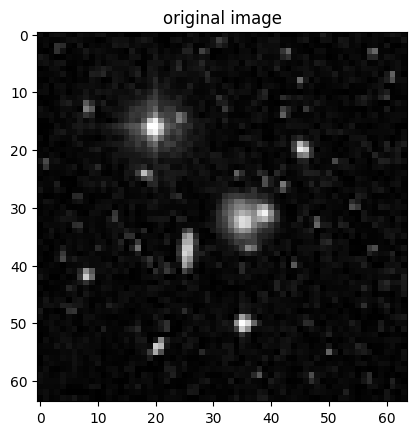

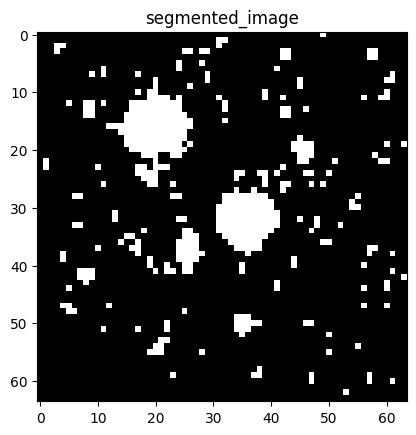

In [ ]:
# Load grayscale image
img = Image.open('download.png').convert('L')
data = np.array(img).flatten().astype(float)

# Initialize GMM parameters
num_clusters = 2
means = np.random.rand(num_clusters) * 255
covs = np.zeros((num_clusters, 1, 1))
covs[:, 0, 0] = np.random.rand(num_clusters) * 255
weights = np.ones(num_clusters) / num_clusters

# EM algorithm
num_iterations = 10000
for i in range(num_iterations):
    # E-step
    responsibilities = np.zeros((len(data), num_clusters))
    for k in range(num_clusters):
        responsibilities[:, k] = weights[k] * \
            np.exp(-(data - means[k])**2 / (2 * covs[k])) / \
            np.sqrt(2 * np.pi * covs[k])
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

    # M-step
    total_resp = np.sum(responsibilities, axis=0)
    means = np.sum(responsibilities * data[:, np.newaxis], axis=0) / total_resp
    covs = np.sum(responsibilities * (data[:, np.newaxis] - means)**2, axis=0) / total_resp
    weights = total_resp / len(data)

# Convert means to integer values and reshape image
means = np.round(means).astype(int)
img_seg = means[np.argmax(responsibilities, axis=1)].reshape(img.size[::-1])

# Display original and segmented images
plt.title("original image")
plt.imshow(img, cmap ='gray')
plt.show()
plt.title("segmented_image")
plt.imshow(img_seg,cmap= 'gray')




In [ ]:
def wavelet_sr(images, scale_factor=4, wavelet='haar', max_iter=10):
    
    """
    ---Wavelet filters---
    "dec_filter" is the decomposition or analysis filter used in wavelet transform. It is a low-pass filter and is applied 
    to the signal being analyzed in order to decompose it into different frequency subbands. The subbands are formed by 
    filtering the signal with a bank of high-pass and low-pass filters at different scales. The decimation or down-sampling
    operation is applied to each subband signal, resulting in a sequence of coefficients at a different resolution level.
    The coefficients at each level correspond to the wavelet transform of the signal at a particular scale.
    
    "rec_filter" is a high-pass reconstruction filter used in the inverse discrete wavelet transform (IDWT) to reconstruct 
    the high-frequency (detail) components of the image from its wavelet coefficients. The filter is used to convolve the 
    wavelet coefficients in the frequency domain and obtain the corresponding high-frequency signals in the spatial domain.
    """
    
    dec_filter, rec_filter = pywt.Wavelet(wavelet).filter_bank[:2]
    
    #wavelet decomposition of high-res image
    high_res_coeffs = pywt.dwt2(images[0], wavelet)
    high_res_coeffs_list = [(high_res_coeffs[0], high_res_coeffs[1])]
    
    #wavelet decomposition of low-res images
    low_res_coeffs_list = []
    for i in range(len(images)):
        coeffs = pywt.dwt2(images[i], wavelet)
        low_res_coeffs_list.append((coeffs[0], coeffs[1]))
    
    estimate_coeffs = high_res_coeffs  #initial estimate
    
    for i in range(max_iter):
        detail_sum = np.zeros_like(high_res_coeffs[1])    #intermediate estimate
        
        for j in range(len(images)):
            high_coeffs = low_res_coeffs_list[j]
            interp_func = interp2d(np.arange(high_coeffs[0].shape[1]), np.arange(high_coeffs[0].shape[0]), high_coeffs[0])
            interp_coeffs = interp_func(np.arange(0, high_coeffs[0].shape[1]-1, 1/scale_factor), np.arange(0, high_coeffs[0].shape[0]-1, 1/scale_factor))
            detail_sum += pywt.idwt2(((None, interp_coeffs, None), rec_filter, rec_filter),wavelet)
            #detail_sum += pywt.idwt2((interp_coeffs,(interp_coeffs, rec_filter, rec_filter)),wavelet)
            
        detail_sum /= len(images)
        estimate_coeffs = (high_res_coeffs[0], detail_sum)
        
        #New wavelet coefficients using EM algorithm
        for j in range(len(images)):
            
            low_coeffs = low_res_coeffs_list[j]
            interp_func = interp2d(np.arange(low_coeffs[0].shape[1]), np.arange(low_coeffs[0].shape[0]), low_coeffs[0])
            interp_coeffs = interp_func(np.arange(0, low_coeffs[0].shape[1]-1, 1/scale_factor), np.arange(0, low_coeffs[0].shape[0]-1, 1/scale_factor))
            new_coeffs = pywt.idwt2((None, interp_coeffs, low_coeffs[1]), rec_filter, rec_filter)
            detail_coeffs = pywt.dwt2(images[j], wavelet)[1]
            detail_coeffs -= pywt.dwt2(new_coeffs, wavelet)[1]
            variance = np.var(detail_coeffs)
            new_coeffs += pywt.idwt2((None, detail_coeffs/np.sqrt(variance)), dec_filter, dec_filter)*np.sqrt(variance)
            low_res_coeffs_list[j] = (new_coeffs, low_coeffs[1])
    
    # Compute final estimate
    final_estimate = pywt.idwt2(estimate_coeffs, rec_filter, rec_filter)
    final_estimate = np.clip(final_estimate, 0, 255).astype(np.uint8)
    
    return final_estimate

4096


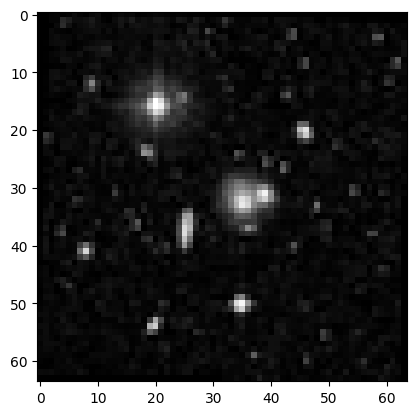

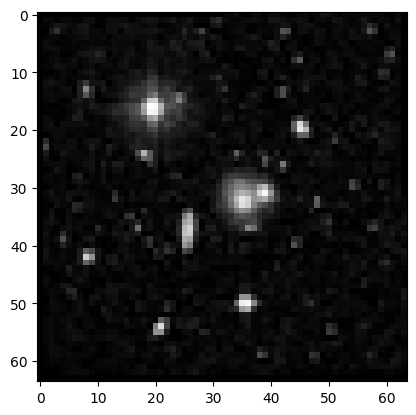

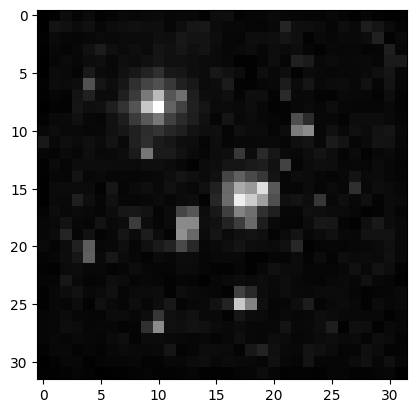

In [ ]:
import pywt
import cv2
import numpy as np

# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef


# Params
FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

# Read the two image
I1 = I_lr[0]
I2 = I_lr[1]

# We need to have both images the same size
I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images
print(I2.size)

## Fusion algo

# First: Do wavelet transform on each image
wavelet = 'haar'
cooef1 = pywt.wavedec2(I1[:,:], wavelet)
cooef2 = pywt.wavedec2(I2[:,:], wavelet)

# Second: for each level in both image do the fusion according to the desire option
fusedCooef = []
for i in range(len(cooef1)-1):

    # The first values in each decomposition is the apprximation values of the top level
    if(i == 0):

        fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

    else:

        # For the rest of the levels we have tupels with 3 coeeficents
        c1 = fuseCoeff(cooef1[i][0],cooef2[i][0],FUSION_METHOD)
        c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
        c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

        fusedCooef.append((c1,c2,c3))

# Third: After we fused the cooefficent we nned to transfor back to get the image
fusedImage = pywt.waverec2(fusedCooef, wavelet)

# Forth: normmalize values to be in uint8
fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
fusedImage = fusedImage.astype(np.uint8)

plt.imshow(I1, cmap = 'gray')
plt.show()

plt.imshow(I2, cmap = 'gray')
plt.show()

# Fith: Show image
plt.imshow(fusedImage, cmap = 'gray')
plt.show()